# 7주차 실습_3

-  DSA dataset을 이용해서, 정상데이터(Lying)과 비정상데이터 설정 (다른 jumping이 아니라 activity 선택)

- Encoder와 Decoder의 구조가 같은 오토인코더로 지난주차와 동일하게 이상치 탐지

- Encoder와 Decoder의 구조가 다른 비대칭형 뉴런수로 성능 확인

- DAE를 사용하여 성능확인

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("/Users/gim-yuseong/Desktop/PycharmProjects/2024_3_2/2024_3_2_딥러닝응용/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df.shape

(9120, 272)

In [4]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

## Denoising AE

DSA데이터에서 lyingRigh, lyingBack(normal), sitting(abnormal)만 남기기

In [5]:
df_filtered = df[df['activity'].isin(['sitting', 'lyingRigh', 'lyingBack'])]
df_filtered = df_filtered.drop('people', axis=1)
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting


In [6]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df_filtered['activity'] = label_encoder.fit_transform(df_filtered['activity'])

df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,6.267229e-07,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,2
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,7.403458e-07,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,2
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,5.802523e-07,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,2
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,5.398837e-07,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,2
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,6.787533e-07,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,2


In [7]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 열 이름의 접두사/접미사를 사용하여 필터링
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']  # 원하는 접두사 리스
columns_to_scale = df_filtered.columns[df_filtered.columns.str.startswith(tuple(prefixes))]

# 선택한 열을 스케일링
df_filtered[columns_to_scale] = scaler.fit_transform(df_filtered[columns_to_scale])

# 스케일링 후 데이터 확인
df_filtered.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.168376,1.179659,1.134716,0.424899,1.794701,-0.037407,1.064111,1.057739,1.076760,-0.084875,...,-0.135903,-0.337940,0.344190,0.054259,0.047582,0.061705,-0.137386,-0.365251,0.185769,2
1,1.168870,1.182732,1.166896,0.154077,1.031924,0.987842,1.078602,1.065174,1.092044,-0.152909,...,-0.135459,-0.325089,-0.608202,0.053994,0.047614,0.061085,-0.137190,-0.361128,0.826319,2
2,1.167436,1.165165,1.166857,-0.022360,0.310479,0.183152,1.078626,1.065149,1.097461,-0.166074,...,-0.136085,-0.343530,-0.295205,0.054349,0.048032,0.062019,-0.137782,-0.373792,0.204012,2
3,1.161106,1.169503,1.136238,0.004198,0.442800,-0.408865,1.084727,1.091232,1.097234,-0.086558,...,-0.136242,-0.348571,0.024825,0.055501,0.049890,0.063365,-0.136432,-0.345871,0.606205,2
4,1.155360,1.173822,1.163969,-0.075787,-0.009354,3.640945,1.090312,1.076313,1.101215,-0.158700,...,-0.135700,-0.331922,-0.323528,0.056609,0.050528,0.064247,-0.137329,-0.364029,0.642770,2


In [8]:
df_filtered['activity'].value_counts()

activity
2    480
0    480
1    480
Name: count, dtype: int64

#### label

0: lyingBack (normal)

1: lyingRigh (normal)

2: sitting (abnormal)

레이블을 두개로 줄여서 해보면,

0: lyingBack, lyingRigh (normal)

1: sitting (abnormal)

In [9]:
# activity가 0 또는 1인 경우 모두 0으로 통합
df_filtered.loc[df_filtered['activity'].isin([0, 1]), 'activity'] = 0
df_filtered.loc[df_filtered['activity'].isin([2]), 'activity'] = 1

In [10]:
df_filtered['activity'].value_counts()

activity
0    960
1    480
Name: count, dtype: int64

Noise Data

In [11]:
df_noised = df_filtered.copy()

noise_factor = np.random.uniform(0, 1)

# 노이즈를 추가할 열 이름의 접두사 설정
prefixes = ['T_', 'RA_', 'LA_', 'RL_', 'LL_']
columns_to_add_noise = df_noised.columns[df_noised.columns.str.startswith(tuple(prefixes))]

# 선택한 열에 노이즈 추가
for column in columns_to_add_noise:
    df_noised[column] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=df_noised[column].shape)

# 노이즈가 추가된 데이터 확인
df_noised

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
0,1.268305,1.304349,0.987030,0.240384,2.110202,0.043291,1.012054,0.768514,1.104023,0.032891,...,-0.196586,-0.238782,0.358958,-0.033733,-0.012442,0.092936,-0.050485,-0.469161,0.056141,1
1,1.134855,1.278290,1.129507,0.119415,0.970169,0.990314,1.042444,0.989244,1.074593,0.070670,...,-0.291988,-0.040645,-0.860591,0.295418,0.326183,-0.042334,-0.156635,-0.431597,0.949959,1
2,1.035993,1.132675,1.522290,-0.059599,0.398521,-0.084234,1.076936,0.816150,1.179490,-0.211413,...,0.011607,-0.372264,-0.370139,0.095912,0.321636,0.182771,-0.056476,-0.288314,0.180842,1
3,1.112550,1.196842,1.273297,-0.051791,0.516736,-0.264923,1.243929,1.389895,1.116279,0.042564,...,-0.064817,-0.442816,0.102526,-0.109029,-0.087568,-0.285986,0.195037,-0.181860,0.632780,1
4,1.146498,1.155148,1.424165,0.132138,0.143444,3.846424,0.944157,1.185579,1.329922,-0.126669,...,0.058448,-0.462876,-0.354601,0.033293,-0.249808,0.144068,-0.143696,-0.269410,0.487803,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,0.237202,0.133160,0.118391,-0.159427,-0.544967,0.493944,-1.562221,-1.838086,-1.228759,-0.144296,...,0.074100,1.188309,0.609057,-0.701621,-0.869379,-0.646881,0.615461,2.224547,-1.006920,0
1916,0.149201,0.182747,0.040762,0.031249,-0.600872,0.709100,-1.453325,-1.738250,-1.791458,-0.166338,...,0.158440,1.285633,0.432929,-0.677307,-0.260665,-0.351256,0.604595,2.014741,2.489977,0
1917,0.330049,-0.160211,0.083086,-0.020054,-0.474640,-0.013225,-1.680385,-1.321922,-1.732518,0.024972,...,-0.025605,0.440270,0.074757,-0.515412,-0.650910,-0.757207,0.215226,1.570354,1.205560,0
1918,0.305561,0.087459,0.191022,-0.306648,-0.486391,-0.179345,-1.630826,-1.737019,-1.417585,-0.108012,...,0.306348,1.299577,0.881081,-0.425682,-0.802614,-0.825695,0.661590,2.404207,2.630604,0


In [12]:
LABELS = ["Normal", "Abnormal"]

In [13]:
# activity가 0 또는 1인 데이터를 선택
# normal = df_filtered[(df_filtered.activity == 0) | (df_filtered.activity == 1)]

normal = df_filtered[(df_noised.activity == 0)]

# activity가 1인 데이터를 선택
abnormal = df_filtered[df_noised.activity == 1]

# normal 데이터프레임의 모양 확인
normal.shape

(960, 271)

In [14]:
abnormal.shape

(480, 271)

Noisiy Data train test split

In [15]:
from sklearn.model_selection import train_test_split

X_noisy_train, X_noisy_test = train_test_split(df_noised, test_size=0.25, random_state=20)

X_noisy_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1010,-0.661720,-1.244131,-1.155301,-0.380526,-0.007373,1.136890,0.590849,0.678873,0.564619,-0.203316,...,-0.140544,-0.467348,-0.236568,-0.740614,-0.838792,-0.743655,0.006931,-0.470887,0.579106,0
1467,0.114429,0.308222,0.071029,0.116047,-0.594506,-0.017635,-0.946232,-1.380518,-1.322861,-0.149266,...,-0.442466,-0.293541,0.348122,-0.512894,-0.493078,-0.402675,-0.061873,-0.700491,0.749064,0
388,1.524247,1.360323,1.298619,0.037442,-0.369688,1.041890,0.325466,0.033209,0.251118,-0.242290,...,-0.129025,-0.417014,0.428090,1.340801,1.482756,1.488042,-0.198970,-0.511882,-0.088874,1
6,1.016112,1.159185,1.293437,-0.233366,0.128697,1.444221,1.020545,1.154062,1.092476,0.097324,...,-0.274847,-0.313980,-0.028517,0.222293,0.065528,-0.106242,-0.172555,-0.586912,0.085898,1
370,1.433938,1.586096,1.439147,0.179831,0.447913,0.496021,-0.049031,0.105218,0.541203,-0.291647,...,-0.087057,-0.402516,-0.230550,1.560491,1.371190,1.438250,-0.148774,-0.210212,0.503151,1


In [16]:
X_noisy_train.shape, X_noisy_test.shape

((1080, 271), (360, 271))

Validation data without noisy

In [17]:
from sklearn.model_selection import train_test_split

X_pure_train, X_pure_test = train_test_split(df_filtered, test_size=0.25, random_state=20)

X_pure_train.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity
1010,-1.290703,-1.285843,-1.287418,-0.055514,0.123063,1.156870,0.628294,0.621916,0.634655,-0.123420,...,-0.136623,-0.361564,-0.377137,-0.776961,-0.784679,-0.769083,-0.135334,-0.325330,0.510677,0
1467,0.077344,0.067253,0.085819,-0.113017,-0.319147,-0.027469,-1.125300,-1.122215,-1.130074,-0.114286,...,-0.132092,-0.249376,0.227977,-0.509727,-0.517653,-0.500863,-0.138148,-0.382040,0.585595,0
388,1.343896,1.351889,1.349909,-0.067704,0.045514,1.214147,0.299451,0.291003,0.306658,-0.136894,...,-0.136532,-0.358346,0.429376,1.425383,1.419654,1.432715,-0.139047,-0.403785,-0.007490,1
6,1.158133,1.157811,1.168282,-0.085738,-0.081536,1.441207,1.083776,1.065074,1.101114,-0.169209,...,-0.136103,-0.344124,-0.056915,0.056377,0.048969,0.063999,-0.136983,-0.356862,-0.076994,1
370,1.427010,1.431069,1.426349,-0.059638,0.097459,0.529919,0.330084,0.325097,0.333491,-0.121270,...,-0.136729,-0.365460,-0.372050,1.410872,1.404854,1.419133,-0.138806,-0.397704,0.417288,1


train/valid에서 sitting 데이터 삭제 (abnormal 삭제)

In [18]:
# normal feature만 가지는 X_noisy_train, X_pure_train
X_noisy_train = X_noisy_train[X_noisy_train.activity == 1]
X_pure_train = X_pure_train[X_pure_train.activity == 1]

y_noisy_train = X_noisy_train['activity']
y_pure_train = X_pure_train['activity']

X_noisy_train = X_noisy_train.drop(['activity'], axis=1)
X_pure_train = X_pure_train.drop(['activity'], axis=1)

X_noisy_train

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
388,1.524247,1.360323,1.298619,0.037442,-0.369688,1.041890,0.325466,0.033209,0.251118,-0.242290,...,0.362601,-0.129025,-0.417014,0.428090,1.340801,1.482756,1.488042,-0.198970,-0.511882,-0.088874
6,1.016112,1.159185,1.293437,-0.233366,0.128697,1.444221,1.020545,1.154062,1.092476,0.097324,...,0.281299,-0.274847,-0.313980,-0.028517,0.222293,0.065528,-0.106242,-0.172555,-0.586912,0.085898
370,1.433938,1.586096,1.439147,0.179831,0.447913,0.496021,-0.049031,0.105218,0.541203,-0.291647,...,0.431263,-0.087057,-0.402516,-0.230550,1.560491,1.371190,1.438250,-0.148774,-0.210212,0.503151
275,0.974832,0.936371,0.915763,-0.137385,-0.076364,0.324570,0.622144,0.800092,0.500070,0.119498,...,1.108334,-0.254646,-0.383160,0.401062,0.733741,0.715104,0.791188,-0.216532,-0.398324,-0.336943
337,1.308522,1.413244,1.338114,0.698985,2.529717,1.912192,0.685208,0.543822,0.635081,0.013961,...,0.754894,-0.150760,-0.419572,-0.215449,0.773596,0.488094,0.716508,-0.372526,-0.080153,0.032744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.520559,1.267958,1.543540,-0.018051,-0.276157,-0.134901,0.434770,0.244034,0.359062,-0.235596,...,0.387478,-0.078077,-0.214037,0.506178,1.235849,1.280288,1.306137,-0.242748,-0.333432,0.183326
282,0.822238,0.891921,0.857351,0.038349,0.123125,-1.285303,0.647390,0.493043,0.599631,-0.342747,...,1.178819,0.077831,-0.726578,0.805934,0.792944,0.774740,0.711544,0.064322,-0.545144,-0.572241
393,1.391456,1.154428,1.305637,0.041351,0.029239,0.685163,0.222581,0.393811,-0.195921,-0.415479,...,0.050430,-0.316427,-0.249597,-0.512565,1.714065,1.450171,1.552410,-0.175307,-0.413977,-0.253325
271,0.916070,1.174686,0.885432,0.016777,-0.109494,-1.339109,0.976970,0.531078,0.582869,-0.182389,...,0.981177,-0.030864,-0.643161,0.366026,0.787279,0.780267,0.877120,0.106220,-0.407560,0.512242


In [19]:
# noisy_test 데이터는 normal과 abnormal label 모두 가지고 있다.

y_noisy_test = X_noisy_test['activity']
X_noisy_test = X_noisy_test.drop(['activity'], axis=1)

X_noisy_test

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
1107,-1.036596,-0.915368,-0.970943,-0.465017,-0.303917,0.711031,0.682493,0.936859,0.621755,0.071246,...,-0.503324,-0.021023,-0.161885,-0.120278,1.400069,1.726801,1.646955,-0.126292,-0.401143,0.352231
1383,-0.530394,-0.777796,-0.697956,-0.014560,-0.485652,-1.289192,0.177095,0.363837,0.255062,0.145256,...,0.231346,0.335356,1.194850,1.974668,-1.023589,-1.015314,-1.105269,0.385772,1.777507,-3.361387
1231,-1.097268,-0.947448,-0.927786,0.124200,0.518543,0.147678,0.469798,0.400783,0.742792,-0.197078,...,-0.339653,-0.241376,-0.073979,0.625628,1.122117,1.322974,1.313160,-0.113074,-0.293869,0.033127
420,0.973980,1.213937,1.326650,0.273041,-0.482277,-0.736792,0.409998,0.648036,0.805261,-0.322575,...,-0.490893,0.321890,1.295821,-0.315240,0.982506,0.942803,1.073599,0.345005,1.222273,1.060107
321,1.703315,1.484170,1.172268,0.006525,0.518402,1.158276,0.957831,0.723623,0.858922,-0.009840,...,0.934813,-0.035684,-0.324585,-0.204435,0.211394,0.221914,0.395038,-0.024932,-0.302628,-0.353970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,-1.223166,-0.863030,-0.796103,-0.150000,-0.287408,-0.342593,0.837062,0.773051,0.643130,-0.191167,...,-0.599087,-0.282077,-0.321533,0.149874,2.021386,1.876239,1.931186,0.095538,-0.329870,0.512238
398,1.342490,1.319407,1.202061,-0.303336,0.117861,0.857737,0.233252,-0.060348,0.034741,-0.052484,...,0.429280,-0.251412,-0.419736,0.083071,1.406105,1.472107,1.309851,-0.011782,-0.441252,-0.473915
1454,0.193138,0.272663,0.125661,-0.226943,-0.114282,0.063168,-1.229421,-1.298044,-0.965686,-0.285498,...,0.468033,0.057145,-0.515112,-0.156401,-0.702209,-0.725537,-0.298438,-0.433263,-0.505653,-0.120503
18,1.315685,1.252734,1.455446,-0.029725,0.004342,0.320120,1.123632,1.236440,1.329407,-0.002427,...,-0.039756,-0.534700,-0.443653,-0.742753,0.338264,0.011202,0.109864,-0.232449,-0.392156,1.499585


In [20]:
# X_train과 X_test를 넘파이 배열로 변환
X_noisy_train = X_noisy_train.values
X_noisy_test = X_noisy_test.values

X_noisy_train

array([[ 1.52424653,  1.36032286,  1.2986188 , ..., -0.19896975,
        -0.51188247, -0.0888735 ],
       [ 1.01611163,  1.15918536,  1.29343748, ..., -0.17255545,
        -0.58691222,  0.08589764],
       [ 1.43393831,  1.58609553,  1.43914678, ..., -0.14877389,
        -0.21021172,  0.50315141],
       ...,
       [ 1.3914556 ,  1.15442839,  1.30563674, ..., -0.17530708,
        -0.41397703, -0.25332483],
       [ 0.91606969,  1.17468638,  0.88543178, ...,  0.10621959,
        -0.40755952,  0.51224169],
       [ 0.98229023,  0.97911105,  0.97564422, ...,  0.49347967,
         1.94047641,  0.56805091]])

In [21]:
import numpy as np
from sklearn.utils import shuffle

X_combined = np.vstack((X_noisy_train, X_pure_train))  # 데이터 합치기
y_combined = np.concatenate((y_noisy_train, y_pure_train))  # 기존 레이블 합치기

X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# 섞인 데이터 확인
X_combined.shape

(704, 270)

In [22]:
y_combined.shape # 섞인 레이블의 크기

(704,)

AE로 Noisy Train & Pure Train 데이터로 모델 학습 (Pure 데이터로 검증)

In [24]:
# 오토인코더 모델

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# 입력 데이터의 차원
input_dim = X_combined.shape[1]
# 인코딩 차원 설정 (압축된 잠재 공간 크기)
encoding_dim = 16  # 임의로 설정한 값, 조정 가능

# 노이즈 추가 함수 (가우시안 노이즈 추가)
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = np.clip(noisy_data, 0., 1.)  # 데이터 범위를 [0, 1]로 제한
    return noisy_data

input_dim = X_combined.shape[1]
encoding_dim = 16  # 인코딩 차원을 설정 (임의로 설정한 값, 조정 가능)

X_combined_noisy = add_noise(X_combined)

# 오토인코더 모델 정의
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)

# 디코딩 단계
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 모델 정의
autoencoder = Model(inputs=input_layer, outputs=decoded)

# 컴파일: 옵티마이저 및 손실 함수 설정
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 모델 구조 요약
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 270)            │         2,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,974 (27.24 KB)

 Trainable params: 6,974 (27.24 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = autoencoder.fit(X_combined, X_combined, epochs=50, batch_size=256, shuffle=True, validation_data=(X_pure_train, X_pure_train))


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0923 - val_loss: 1.1884
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2635 - val_loss: 1.1850
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2210 - val_loss: 1.1809
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2602 - val_loss: 1.1757
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1046 - val_loss: 1.1690
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1762 - val_loss: 1.1605
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1727 - val_loss: 1.1501
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1109 - val_loss: 1.1376
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0980 - val_loss: 1.1229
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1033 - val_loss: 1.1061
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0736 - val_loss: 1.0874
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0476 - val_loss: 1.0671
Epoch 13/50

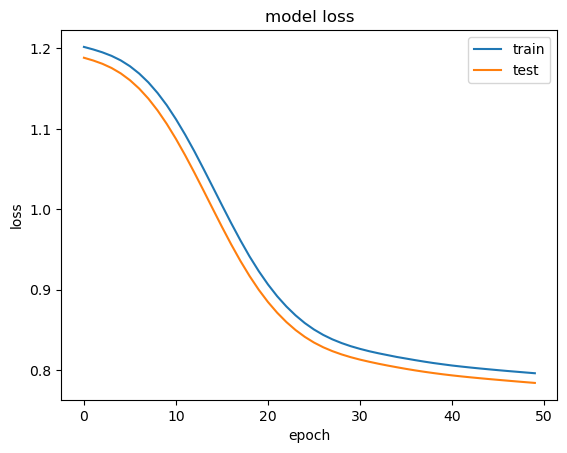

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Noisy 데이터로 AE 예측

In [27]:
# X_noisy_test 값을 넣어서 Reconstruction Error 값을 얻고,
# 실제 레이블인 y_noisy_test와 데이터프레임으로 구성
# Reconstruction Error + 실제 레이블의 형태가 됨

predictions = autoencoder.predict(X_noisy_test)
mse = np.mean(np.power(X_noisy_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_noisy_test})
error_df.describe()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,reconstruction_error,true_class
count,360.000000,360.000000
mean,1.069172,0.355556
std,3.738598,0.479348
min,0.221359,0.000000
25%,0.379831,0.000000
50%,0.551684,0.000000
75%,0.857258,1.000000
max,61.263250,1.000000


In [28]:
error_df = error_df.reset_index(drop=True)
error_df

,reconstruction_error,true_class
0,0.855323,0
1,0.568207,0
2,0.286343,0
3,0.611730,1
4,0.335222,1
...,...,...
355,0.676832,0
356,0.348036,1
357,0.801293,0
358,0.339036,1


In [29]:
threshold = 0.855323

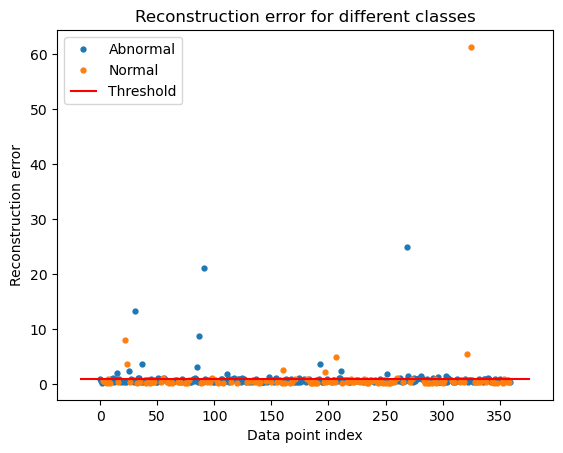

In [30]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Abnormal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

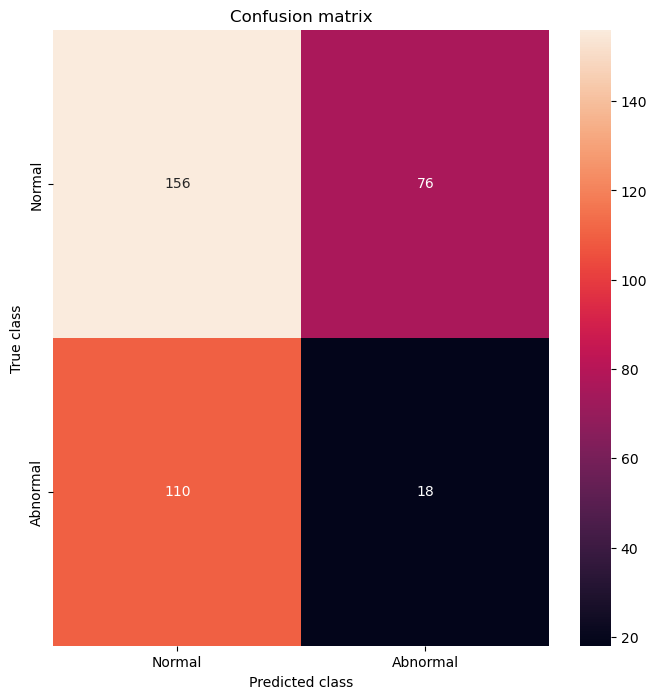

              precision    recall  f1-score   support

           0       0.59      0.67      0.63       232
           1       0.19      0.14      0.16       128

    accuracy                           0.48       360
   macro avg       0.39      0.41      0.39       360
weighted avg       0.45      0.48      0.46       360



In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))